In [2]:
#Import needed packages

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_curve
from sklearn import metrics

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, KFold


SMOTE for imbalance


In [3]:
#load preprocessed data
mrna_x = pd.read_csv('zscore_mutation.csv')
mrna_x.drop(columns=mrna_x.columns[0], axis=1, inplace=True)
print(mrna_x.head())

#mrna_x.drop('target', axis=1, inplace=True)
y = np.load('processed_recurrence_data_zscore_mutation.npy')
print(mrna_x.shape)
X_train, X_test, y_train, y_test = train_test_split(mrna_x.values, y,
                                                    train_size=0.75, test_size=0.25)

age = np.load('age_data_mutation.npy')
gender = np.load('gender_data_mutation.npy')
stage = np.load('stage_data_mutation.npy')

# Try using lasso (feature selection), feature importance, shap


   LOC100130426  UBE2Q2P3  UBE2Q2P3.1  TIMM23  LOC155060  RNU12-2P    SSX9  \
0       -3.0863    0.3223     -0.7343  0.1476     0.9885   -0.1476 -0.9372   
1       -3.0863    1.4031      1.3759 -1.3732     2.0512   -0.5081 -0.9372   
2       -3.0863    1.5672      1.6364  0.4353     0.6953    1.2612 -0.9372   
3       -3.0863    0.9756      1.2166  0.0829     0.2252    0.5166 -0.9372   
4       -3.0863    1.2136      1.5562 -1.1680     0.5609    0.4829 -0.9372   

    EZHIP  EFCAB8  SRP14P1  ...  ZSWIM6 Mutation  ZSWIM8 Mutation  \
0  0.6324  5.0700  -0.2790  ...                0                0   
1 -0.3527 -0.5518   0.4855  ...                0                0   
2 -1.5927  0.2084  -1.5463  ...                0                0   
3 -0.8073 -1.5707  -2.1707  ...                0                1   
4 -1.5927 -1.5707  -1.6107  ...                0                0   

   ZUFSP Mutation  ZW10 Mutation  ZWINT Mutation  ZXDA Mutation  \
0               0              0               0 

In [4]:
print(y.shape)

(366,)


In [5]:
mrna_x.shape

(366, 31300)

In [6]:
print(mrna_x.values)

[[-3.0863  0.3223 -0.7343 ...  0.      0.      0.    ]
 [-3.0863  1.4031  1.3759 ...  0.      0.      0.    ]
 [-3.0863  1.5672  1.6364 ...  0.      0.      0.    ]
 ...
 [-3.0863 -1.1901  0.5716 ...  0.      0.      0.    ]
 [-1.1093  0.1797 -1.2507 ...  0.      0.      0.    ]
 [-3.0863  0.805   0.5794 ...  0.      0.      0.    ]]


In [7]:
# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()

# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(mrna_x.values, y)
print("Best Params {}".format(lasso_cv.best_params_))

c:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.657e-02, tolerance: 6.067e-03
  model = cd_fast.enet_coordinate_descent(
c:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.828e-02, tolerance: 6.311e-03
  model = cd_fast.enet_coordinate_descent(
c:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.731e-02, tolerance: 6.235e-03
  model = cd_fast.enet_coo

Best Params {'alpha': 1e-05}


c:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.328e-02, tolerance: 7.811e-03
  model = cd_fast.enet_coordinate_descent(


In [8]:
names=mrna_x.columns
print("Column Names: {}".format(names.values))
print(len(names))

Column Names: ['LOC100130426' 'UBE2Q2P3' 'UBE2Q2P3.1' ... 'ZYG11B Mutation'
 'ZYX Mutation' 'ZZEF1 Mutation']
31300


In [9]:
# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)




c:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.632e-02, tolerance: 5.938e-03
  model = cd_fast.enet_coordinate_descent(


In [10]:
feature_subset=np.array(names)[lasso1_coef>0.01]
print("Selected Feature Columns: {}".format(feature_subset))
print(len(feature_subset))

lasso_x = mrna_x[feature_subset]
print(lasso_x.shape)

lasso_x['Age'] = age
lasso_x['Gender'] = gender
lasso_x['Stage'] = stage


X_train_1, X_test_testing, y_train_1, y_test_testing = train_test_split(lasso_x.values, y,
                                                    train_size=0.80, test_size=0.20, shuffle=True, random_state=123)
X_train, X_test, y_train, y_test = train_test_split(X_train_1, y_train_1,
                                                    train_size=0.75, test_size=0.25, shuffle=True, random_state=123)

Selected Feature Columns: ['LOC100130426' 'UBE2Q2P3' 'UBE2Q2P3.1' 'TIMM23' 'LOC155060' 'EZHIP'
 'LOC391343' 'SPATA31B1P' 'KIAA1618' 'LOC645851' 'RGPD7' 'TMPRSS11E2'
 'A1CF' 'RBFOX1' 'A2ML1' 'NPSR1-AS1' 'AAAS' 'AACS' 'AADACL4' 'AADAT'
 'AAGAB' 'AAMP' 'AARS' 'AASDHPPT' 'AASDH' 'AATK' 'ABCA12' 'ABCA17P'
 'ABCA2' 'STGD1' 'ABCA5' 'ABCA8' 'ABCB10' 'PFIC2' 'ABCB1' 'ABCB5' 'ABCC1'
 'ABCC2' 'ABCC3' 'ABCC9' 'ABCF1' 'ABCG2' 'ABHD11' 'ABHD13' 'ABI3' 'ABL1'
 'ABL2' 'ABO' 'ABRA' 'ABTB2' 'ACACA' 'ACAD11' 'ACADS' 'ACAN' 'ACAT2'
 'ACBD4' 'ASIC2' 'ASIC4' 'ACCSL' 'ACHE' 'ACLY' 'IREB1' 'ACOT1' 'ACOT2'
 'ACOT6' 'ACOX1' 'ACOX2' 'ACOXL' 'ACP5' 'PXYLP1' 'ACPT' 'ACSBG2' 'ACSF3'
 'MRX63' 'ACSM1' 'ACTC1' 'ACTL7A' 'ACTL7B' 'ACTR10' 'ACVR1C' 'ADAM20'
 'ADAM21P1' 'ADAM30' 'ADAM5' 'ADAMTS16' 'ADAMTS17' 'ADAMTS20' 'ADAMTS8'
 'ADAMTSL4' 'ADAMTSL5' 'ADAT2' 'ADCY10' 'DFNB44' 'AZIN2' 'ADH1C' 'ADI1'
 'ADORA2A' 'ADRA2C' 'ADRB3' 'C11orf96' 'AGA' 'AGMAT' 'AGPAT5' 'HYKK'
 'AGR3' 'PHYKPL' 'AHSA1' 'AHSG' 'AIMP1' 'AKAP4' 'AKAP8L

C:\Users\nitin\AppData\Local\Temp\ipykernel_18364\240925628.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lasso_x['Age'] = age
C:\Users\nitin\AppData\Local\Temp\ipykernel_18364\240925628.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lasso_x['Gender'] = gender
C:\Users\nitin\AppData\Local\Temp\ipykernel_18364\240925628.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

X_train_full, X_test_full, y_train, y_test = train_test_split(mrna_x.values, y,
train_size=0.75, test_size=0.25, shuffle=True, random_state=123)


In [11]:
pos_x_train = []
neg_x_train = []
print(type(X_train))
for i in range(len(X_train)):
    if y_train[i] == 1:
        pos_x_train.append(X_train[i])
    else:
        neg_x_train.append(X_train[i])
pos_x_train = np.array(pos_x_train)
neg_x_train = np.array(neg_x_train)


<class 'numpy.ndarray'>


In [12]:
batches = []
batches_y = []

num_batches = 50

batch_size = 32

c = 0
for i in range(num_batches):
    batch = []
    batch_y = []
    temp = np.random.permutation(len(pos_x_train))[:int(batch_size/2)]
    for t in temp:
        batch.append(pos_x_train[t])
        batch_y.append(1)
    temp = np.random.permutation(len(neg_x_train))[:int(batch_size/2)]
    for t in temp:
        batch.append(neg_x_train[t])
        batch_y.append(0)
    batch = np.array(batch)
    batches.append(batch)
    batch_y = np.array(batch_y)
    batches_y.append(batch_y)



In [13]:
pos=sum(y)
total = len(y)
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 366
    Positive: 113 (30.87% of total)



In [14]:
#make and compile the Neural Network model
from sklearn.metrics import f1_score
'''
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(200, input_shape=(20531,),activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(2, activation='softmax')

])

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      optimizer = tf.keras.optimizers.Adam(), metrics=['accuracy'])

'''
x = lasso_x.shape[1]

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(x, input_shape=(x,),activation=tf.nn.relu),
  tf.keras.layers.Dense(int(x/2), activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation='sigmoid')

])

model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.BinaryCrossentropy()])

In [15]:
#import keras_tuner as kt

#tuner = kt.Hyperband()

In [16]:
import keras_tuner as kt
model_builder = None
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     )

regulizors


In [17]:
weights = {}
num_samples = len(y_train)
pos_count = sum(y_train)
neg_count =  num_samples - pos_count

weights[0] = num_samples / (2 * neg_count)
weights[1] = num_samples / (2 * pos_count)


print(weights, num_samples, pos_count, neg_count)

{0: 0.73, 1: 1.5869565217391304} 219 69 150


In [18]:
weights

{0: 0.73, 1: 1.5869565217391304}

In [19]:
#Train the model on the cBioPortal data

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3)

model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), class_weight = weights, callbacks=[es])

#Validate the model

model.evaluate(X_test, y_test, verbose=2)


Epoch 1/100


7/7 [==============================] - 2s 50ms/step - loss: 0.8712 - accuracy: 0.5388 - binary_crossentropy: 0.8884 - val_loss: 0.6064 - val_accuracy: 0.7123 - val_binary_crossentropy: 0.6064
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 0.5550 - accuracy: 0.7489 - binary_crossentropy: 0.5153 - val_loss: 0.7475 - val_accuracy: 0.6164 - val_binary_crossentropy: 0.7475
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 0.4580 - accuracy: 0.7534 - binary_crossentropy: 0.4870 - val_loss: 0.4986 - val_accuracy: 0.7671 - val_binary_crossentropy: 0.4986
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 0.3343 - accuracy: 0.8539 - binary_crossentropy: 0.3522 - val_loss: 0.4868 - val_accuracy: 0.7808 - val_binary_crossentropy: 0.4868
Epoch 5/100
7/7 [==============================] - 0s 10ms/step - loss: 0.2709 - accuracy: 0.9269 - binary_crossentropy: 0.2745 - val_loss: 0.5026 - val_accuracy: 0.7397 - val_binary_c

[0.4672997295856476, 0.8493150472640991, 0.4672997295856476]

In [20]:
#Train the model on the cBioPortal data
y_prob = model.predict(X_test)
y_pred = 1*(y_prob > 0.5)
f1_score(y_test, y_pred)


3/3 [==============================] - 0s 2ms/step


0.717948717948718

In [21]:
from sklearn.metrics import classification_report

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90        52
           1       0.78      0.67      0.72        21

    accuracy                           0.85        73
   macro avg       0.83      0.79      0.81        73
weighted avg       0.85      0.85      0.85        73



In [23]:
y_prob_tf = model.predict(X_test_testing)
y_pred_tf = 1*(y_prob_tf > 0.5)

3/3 [==============================] - 0s 3ms/step


In [ ]:
y_prob_tf

array([[9.8114109e-01],
       [9.9603570e-01],
       [1.4296116e-01],
       [5.6204341e-02],
       [4.6842117e-03],
       [4.8583472e-01],
       [1.1293616e-01],
       [2.5871634e-03],
       [5.2613165e-02],
       [1.6289820e-01],
       [1.7663715e-02],
       [9.6340972e-01],
       [9.8761868e-01],
       [2.0153702e-03],
       [9.8971945e-01],
       [8.3071198e-03],
       [3.1421355e-03],
       [3.7941939e-01],
       [8.4321392e-01],
       [6.6942319e-02],
       [3.2629408e-02],
       [9.1828537e-01],
       [7.0941538e-01],
       [2.9340911e-01],
       [2.1208711e-03],
       [9.6795008e-02],
       [5.2431428e-01],
       [8.9517504e-04],
       [8.9101899e-01],
       [2.5350031e-01],
       [1.4900715e-03],
       [2.3444299e-01],
       [4.5916300e-02],
       [1.5228561e-01],
       [1.3706501e-01],
       [7.4971402e-01],
       [7.0590876e-02],
       [2.6535751e-02],
       [8.1083769e-01],
       [8.4099348e-04],
       [5.5993898e-03],
       [9.982490

: 

In [71]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = 1000, max_iter=2000, class_weight=weights, penalty='l1', solver='liblinear', random_state=123)
lr.fit(X_train, y_train)
print(lr.score(X_test_testing, y_test_testing))
acc_lr = lr.score(X_test_testing, y_test_testing)
y_prob_lr = lr.predict_proba(X_test_testing)[:,1]
y_pred_lr = lr.predict(X_test_testing)

0.8918918918918919


In [72]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth = 15)
rf.fit(X_train, y_train)
print(rf.score(X_test_testing, y_test_testing))
acc_rf = rf.score(X_test_testing, y_test_testing)
y_prob_rf = rf.predict_proba(X_test_testing)[:,1]
y_pred_rf = rf.predict(X_test_testing)

0.7972972972972973


In [73]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(num_leaves = 3, verbose=0)
lgb.fit(X_train, y_train)
print(lgb.score(X_test_testing, y_test_testing))
acc_lgb = lgb.score(X_test_testing, y_test_testing)
y_prob_lgb = lgb.predict_proba(X_test_testing)[:,1]
y_pred_lgb = lgb.predict(X_test_testing)

0.8243243243243243


In [74]:
from sklearn.svm import SVC
svc = SVC(probability=True, C=1000, kernel='linear')
svc.fit(X_train, y_train)
print(svc.score(X_test_testing, y_test_testing))
acc_svc = svc.score(X_test_testing, y_test_testing)
y_prob_svc = svc.predict_proba(X_test_testing)[:,1]
y_pred_svc = svc.predict(X_test_testing)

0.8918918918918919


In [75]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier()
kn.fit(X_train, y_train)
print(kn.score(X_test_testing, y_test_testing))
acc_kn = kn.score(X_test_testing, y_test_testing)
y_prob_kn = kn.predict_proba(X_test_testing)[:,1]
y_pred_kn = kn.predict(X_test_testing)



0.7297297297297297


In [76]:
from sklearn.ensemble import AdaBoostClassifier

adb = AdaBoostClassifier(random_state=123)
adb.fit(X_train, y_train)
print(adb.score(X_test_testing, y_test_testing))
acc_adb = adb.score(X_test_testing, y_test_testing)
y_prob_adb = adb.predict_proba(X_test_testing)[:,1]
y_pred_adb = adb.predict(X_test_testing)

0.8243243243243243


In [77]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train, y_train)
print(bnb.score(X_test_testing, y_test_testing))
acc_bnb = bnb.score(X_test_testing, y_test_testing)
y_prob_bnb = bnb.predict_proba(X_test_testing)[:,1]
y_pred_bnb = bnb.predict(X_test_testing)


0.7837837837837838


In [78]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=123, learning_rate= 'constant', solver= 'lbfgs', activation = 'tanh', alpha = 0.05)

parameter_space = {
    'activation': ['relu', 'identity', 'logistic', 'tanh'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.05, 0.001],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

print('Best parameters found:\n', clf.best_params_)


mlp.fit(X_train, y_train)
print(mlp.score(X_test_testing, y_test_testing))
acc_mlp = mlp.score(X_test_testing, y_test_testing)
y_prob_mlp = mlp.predict_proba(X_test_testing)[:,1]
y_pred_mlp = mlp.predict(X_test_testing)

c:\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Best parameters found:
 {'activation': 'logistic', 'alpha': 0.0001, 'learning_rate': 'constant', 'solver': 'adam'}
0.8648648648648649


c:\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



In [79]:
from sklearn.ensemble import GradientBoostingClassifier

sgb = GradientBoostingClassifier(random_state=123, subsample = 0.5)

sgb.fit(X_train, y_train)
print(sgb.score(X_test_testing, y_test_testing)) 
acc_sgb = sgb.score(X_test_testing, y_test_testing)

y_prob_sgb = sgb.predict_proba(X_test_testing)[:,1]
y_pred_sgb = sgb.predict(X_test_testing)

0.8378378378378378


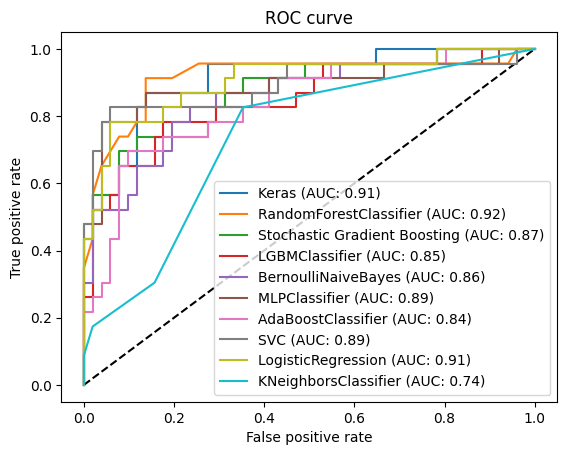

: 

In [97]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

fpr, tpr, thresholds = roc_curve(y_test_testing, y_prob_tf)
auc_val = metrics.auc(fpr, tpr)
auc_tf = auc_val
plt.plot(fpr, tpr, label='Keras (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test_testing, y_prob_rf)
auc_val = metrics.auc(fpr, tpr)
auc_rf = auc_val
plt.plot(fpr, tpr, label='RandomForestClassifier (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test_testing, y_prob_sgb)
auc_val = metrics.auc(fpr, tpr)
auc_sgb = auc_val
plt.plot(fpr, tpr, label='Stochastic Gradient Boosting (AUC: {:.2f})'.format(auc_val))


fpr, tpr, thresholds = roc_curve(y_test_testing, y_prob_lgb)
auc_val = metrics.auc(fpr, tpr)
auc_lgb = auc_val
plt.plot(fpr, tpr, label='LGBMClassifier (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test_testing, y_prob_bnb)
auc_val = metrics.auc(fpr, tpr)
auc_bnb = auc_val
plt.plot(fpr, tpr, label='BernoulliNaiveBayes (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test_testing, y_prob_mlp)
auc_val = metrics.auc(fpr, tpr)
auc_mlp = auc_val
plt.plot(fpr, tpr, label='MLPClassifier (AUC: {:.2f})'.format(auc_val))


fpr, tpr, thresholds = roc_curve(y_test_testing, y_prob_adb)
auc_val = metrics.auc(fpr, tpr)
auc_adb = auc_val
plt.plot(fpr, tpr, label='AdaBoostClassifier (AUC: {:.2f})'.format(auc_val))



fpr, tpr, thresholds = roc_curve(y_test_testing, y_prob_svc)
auc_val = metrics.auc(fpr, tpr)
auc_svc = auc_val
plt.plot(fpr, tpr, label='SVC (AUC: {:.2f})'.format(auc_val))



fpr, tpr, thresholds = roc_curve(y_test_testing, y_prob_lr)
auc_val = metrics.auc(fpr, tpr)
auc_lr = auc_val
plt.plot(fpr, tpr, label='LogisticRegression (AUC: {:.2f})'.format(auc_val))



fpr, tpr, thresholds = roc_curve(y_test_testing, y_prob_kn)
auc_val = metrics.auc(fpr, tpr)
auc_kn = auc_val
plt.plot(fpr, tpr, label='KNeighborsClassifier (AUC: {:.2f})'.format(auc_val))


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [81]:
clas_tf = classification_report(y_test_testing, y_pred_tf, output_dict=True)
clas_lr = classification_report(y_test_testing, y_pred_lr, output_dict=True)
clas_rf = classification_report(y_test_testing, y_pred_rf, output_dict=True)
clas_lgb = classification_report(y_test_testing, y_pred_lgb, output_dict=True)
clas_svc = classification_report(y_test_testing, y_pred_svc, output_dict=True)
clas_kn = classification_report(y_test_testing, y_pred_kn, output_dict=True)
clas_adb = classification_report(y_test_testing, y_pred_adb, output_dict=True)
clas_bnb = classification_report(y_test_testing, y_pred_bnb, output_dict=True)
clas_mlp = classification_report(y_test_testing, y_pred_mlp, output_dict=True)
clas_sgb = classification_report(y_test_testing, y_pred_sgb, output_dict=True)




In [82]:
clas_tf

{'0': {'precision': 0.8518518518518519,
  'recall': 0.9019607843137255,
  'f1-score': 0.8761904761904761,
  'support': 51},
 '1': {'precision': 0.75,
  'recall': 0.6521739130434783,
  'f1-score': 0.6976744186046512,
  'support': 23},
 'accuracy': 0.8243243243243243,
 'macro avg': {'precision': 0.8009259259259259,
  'recall': 0.7770673486786019,
  'f1-score': 0.7869324473975636,
  'support': 74},
 'weighted avg': {'precision': 0.8201951951951951,
  'recall': 0.8243243243243243,
  'f1-score': 0.8207057555894766,
  'support': 74}}

In [95]:
clas_df = pd.DataFrame(columns=['Algorithms','AUC', 'Accuracy', 'Sensitivity', 'Specificity', 'F1 Score'])
clas_df.loc[len(clas_df)] = ['Tensorflow' , auc_tf, clas_tf['accuracy'], clas_tf['1']['recall'], clas_tf['0']['recall'], clas_tf['weighted avg']['f1-score']]
clas_df.loc[len(clas_df)] = ['Random Forest', auc_rf, clas_rf['accuracy'], clas_rf['1']['recall'], clas_rf['0']['recall'], clas_rf['weighted avg']['f1-score']]
clas_df.loc[len(clas_df)] = ['Stochastic Gradient Boosting', auc_sgb, clas_sgb['accuracy'], clas_sgb['1']['recall'], clas_sgb['0']['recall'], clas_sgb['weighted avg']['f1-score']]
clas_df.loc[len(clas_df)] = ['LGBM Classifer', auc_lgb, clas_lgb['accuracy'], clas_lgb['1']['recall'], clas_lgb['0']['recall'], clas_lgb['weighted avg']['f1-score']]
clas_df.loc[len(clas_df)] = ['Bernoulli Naive Bayes', auc_bnb, clas_bnb['accuracy'], clas_bnb['1']['recall'], clas_bnb['0']['recall'], clas_bnb['weighted avg']['f1-score']]
clas_df.loc[len(clas_df)] = ['MLP Classifer', auc_mlp, clas_mlp['accuracy'], clas_mlp['1']['recall'], clas_mlp['0']['recall'], clas_mlp['weighted avg']['f1-score']]
clas_df.loc[len(clas_df)] = ['Adaboost Classifer', auc_adb, clas_adb['accuracy'], clas_adb['1']['recall'], clas_adb['0']['recall'], clas_adb['weighted avg']['f1-score']]
clas_df.loc[len(clas_df)] = ['SVC', auc_svc, clas_svc['accuracy'], clas_svc['1']['recall'], clas_svc['0']['recall'], clas_svc['weighted avg']['f1-score']]
clas_df.loc[len(clas_df)] = ['Logistic Regression', auc_lr, clas_lr['accuracy'], clas_lr['1']['recall'], clas_lr['0']['recall'], clas_lr['weighted avg']['f1-score']]
clas_df.loc[len(clas_df)] = ['K Neighboors Classifer', auc_kn, clas_kn['accuracy'], clas_kn['1']['recall'], clas_kn['0']['recall'], clas_kn['weighted avg']['f1-score']]





clas_df.style.format(precision=3, thousands=',', decimal='.')

print(clas_df)

clas_df.to_csv('metrics.csv', index=False)

                     Algorithms       AUC  Accuracy  Sensitivity  Specificity  \
0                    Tensorflow  0.911338  0.824324     0.652174     0.901961   
1                 Random Forest  0.915175  0.797297     0.347826     1.000000   
2  Stochastic Gradient Boosting  0.873828  0.837838     0.521739     0.980392   
3                LGBM Classifer  0.847400  0.824324     0.565217     0.941176   
4         Bernoulli Naive Bayes  0.856777  0.783784     0.782609     0.784314   
5                 MLP Classifer  0.889173  0.864865     0.782609     0.901961   
6            Adaboost Classifer  0.838022  0.824324     0.652174     0.901961   
7                           SVC  0.893436  0.891892     0.826087     0.921569   
8           Logistic Regression  0.906223  0.891892     0.782609     0.941176   
9        K Neighboors Classifer  0.736999  0.729730     0.173913     0.980392   

   F1 Score  
0  0.820706  
1  0.761250  
2  0.822555  
3  0.814200  
4  0.789501  
5  0.864865  
6  0.82070

In [85]:
'''import shap
explainer = shap.DeepExplainer(model, X_train[:100])
shap_values = explainer.shap_values(X_test[:10])

shap.initjs()

test = shap_values[:,:,0]

print(shap_values[:,:,0].shape)
shap.force_plot(explainer.expected_value[0], test[0], feature_list)
'''




'import shap\nexplainer = shap.DeepExplainer(model, X_train[:100])\nshap_values = explainer.shap_values(X_test[:10])\n\nshap.initjs()\n\ntest = shap_values[:,:,0]\n\nprint(shap_values[:,:,0].shape)\nshap.force_plot(explainer.expected_value[0], test[0], feature_list)\n'

In [86]:
feature_list = feature_subset.tolist()
feature_list.append('Age')
feature_list.append('Gender')
feature_list.append('Stage')
feature_list = np.array(feature_list)



In [87]:
lasso_x

,UBE2Q2P3.1,TIMM23,LOC155060,EZHIP,SPATA31B1P,KIAA1618,LOC645851,RGPD7,TMPRSS11E2,GTPBP6,...,TBC1D3P1-DHX40P1,EFHB,FAM3D,FAM90A1,LDHC,ZNF300P1,PABPC1L2A,Age,Gender,Stage
0,-0.7343,0.1476,0.9885,0.6324,-3.1335,0.2856,0.9154,0.0736,-0.6761,-0.2374,...,-1.3720,-0.8095,0.0431,0.6673,-0.1804,-0.0119,-1.9193,77,1,2
1,1.3759,-1.3732,2.0512,-0.3527,-3.1335,-1.1747,-0.0241,-2.7468,0.3698,-0.1531,...,-1.3720,-0.9310,-0.5769,-0.6140,1.0491,-0.3557,-1.9193,57,0,1
2,1.6364,0.4353,0.6953,-1.5927,-3.1335,1.3950,1.3422,-2.7468,-0.6761,-0.3986,...,-1.3720,0.2817,-1.5236,0.8820,-1.3381,0.6310,-1.9193,67,0,1
3,1.2166,0.0829,0.2252,-0.8073,-3.1335,1.5120,0.8096,-2.7468,-0.6761,-1.2019,...,-1.3720,2.5949,0.8390,2.3969,1.4487,-1.9741,-1.9193,70,0,0
4,1.5562,-1.1680,0.5609,-1.5927,-3.1335,1.0482,1.0092,-1.3212,-0.6761,0.1637,...,-0.3178,-0.5937,0.5286,-1.4352,-1.3381,1.7096,-1.9193,52,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,-0.5201,-0.1529,-1.0120,-1.5927,-3.1335,-0.2139,-0.7108,-1.4076,-0.6761,-0.3644,...,-1.3720,0.1271,0.5756,0.1051,-1.3381,-0.5566,-1.9193,52,1,0
362,-1.1065,-1.7599,-0.2565,-0.8109,-3.1335,0.2862,-0.9437,-2.7468,-0.4595,-0.0995,...,-1.3720,0.8536,1.3723,-0.8410,-1.0694,0.8185,-1.9193,47,1,0
363,0.5716,0.4635,-1.2582,-0.4238,-3.1335,1.3109,-1.5829,-0.3846,-0.6761,-0.0447,...,-0.1924,-0.6931,0.4511,0.4309,-0.6293,1.2116,-1.9193,67,1,0
364,-1.2507,-1.2740,-1.1998,-1.0326,-3.1335,0.8243,-0.3896,1.1191,-0.6761,-1.5128,...,-1.3720,-1.4537,0.5511,-0.9150,-0.8680,-0.1098,-1.9193,55,0,0


In [88]:
def keras_model(X):
    return model.predict(X, verbose=False).flatten()

In [89]:
X_test.shape

(73, 231)

In [90]:
X_test_testing.shape

(74, 231)

In [91]:
import shap
explainer = shap.KernelExplainer(keras_model, X_test_testing[:20])
shap_values = explainer.shap_values(X_test_testing[20:40])


  0%|          | 0/20 [00:00<?, ?it/s]

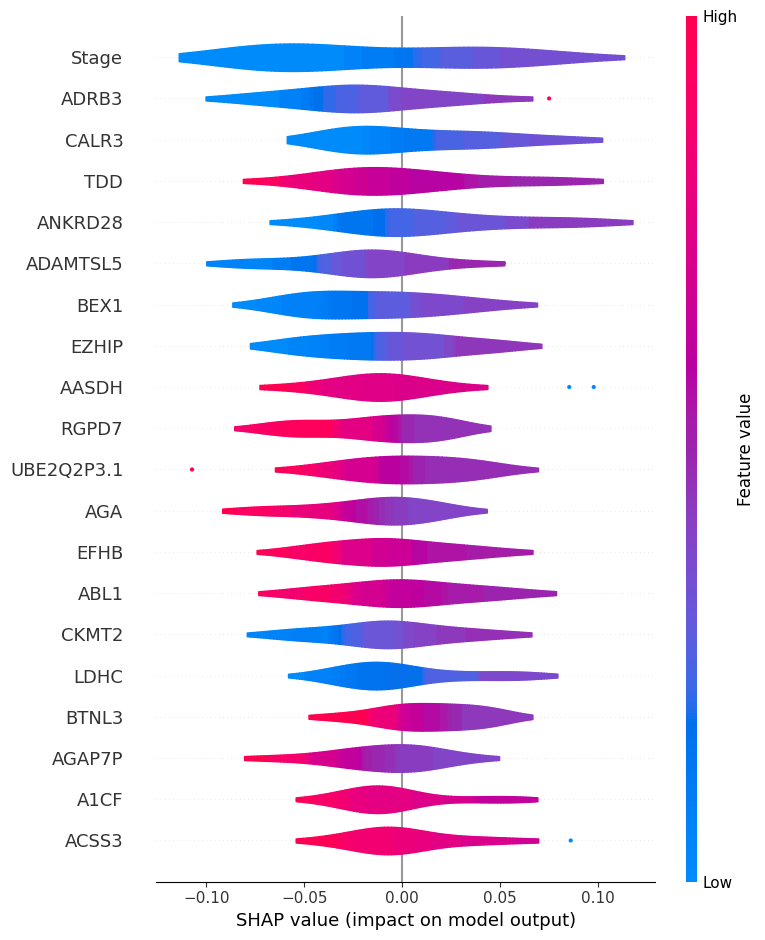

In [92]:
#shap.initjs()
shap.summary_plot(shap_values,X_test_testing[20:40],feature_names=feature_list, plot_type="violin")
plt.show()


In [93]:
asbsad

NameError: name 'asbsad' is not defined

In [ ]:
type(explainer)

shap.explainers._kernel.KernelExplainer

In [ ]:
shap.plots.beeswarm(shap_values)

TypeError: The beeswarm plot requires an `Explanation` object as the `shap_values` argument.

In [ ]:
shap.force_plot(explainer.expected_value, shap_values )

In [ ]:
print(shap_values.shape)
print(X_test[:1].shape)

(20, 1307, 1)
(1307,)


In [ ]:
print(shap_values)

[[[ 0.        ]
  [ 0.        ]
  [-0.00406098]
  ...
  [ 0.03611475]
  [ 0.        ]
  [-0.00394583]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [-0.08266036]
  [ 0.00263166]
  [ 0.00645278]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [-0.00245485]
  [ 0.        ]
  [ 0.        ]]

 ...

 [[ 0.00158825]
  [ 0.        ]
  [-0.0070686 ]
  ...
  [ 0.02979047]
  [ 0.        ]
  [-0.00523747]]

 [[ 0.        ]
  [ 0.00416919]
  [-0.00276461]
  ...
  [ 0.06595436]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [-0.0905685 ]
  [ 0.        ]
  [ 0.00603381]]]


In [ ]:
import sklearn
import shap
from sklearn.model_selection import train_test_split

# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier
X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][:,0], X_test.iloc[0,:], link="logit")



c:\Python39\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Python39\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Python39\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# train a SVM classifier

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model.predict(X_train), X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][:,0], X_test.iloc[0,:], link="logit")

11/11 [==============================] - 0s 3ms/step
Provided model function fails when applied to the provided data set.


TypeError: 'numpy.ndarray' object is not callable

In [ ]:
print(X_test.shape)
print(shap_values.shape)

(30, 4)
(30, 4, 3)


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)


553467096/553467096 [==============================] - 39s 0us/step


TypeError: Tensors are unhashable (this tensor: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")). Instead, use tensor.ref() as the key.

In [ ]:
background = X_train[np.random.choice(x_train.shape[0], 100, replace=False)]
